# Calculations with the ENSO Longitude Index

This notebook calculates the most recent ENSO Longitude Index (ELI) from Williams and Patricola 2018.  Based on https://github.com/mktippett/NMME/blob/master/ELI.ipynb and [Williams and Patricola (2018)](https://doi.org/10.1029/2018GL079203).

## Sources and instructions

Patricola, C.M., O’Brien, J.P., Risser, M.D. et al. Maximizing ENSO as a source of western US hydroclimate predictability. Clim Dyn 54, 351–372 (2020). https://doi.org/10.1007/s00382-019-05004-8

Williams, I. N., & Patricola, C. M. (2018). Diversity of ENSO events unified by convective threshold sea surface temperature: A nonlinear ENSO index. Geophysical Research Letters, 45, 9236–9244. https://doi.org/10.1029/2018GL079203

'ELI is calculated by first, for each month, calculating the tropical-average SST over 5°S–5°N, to estimate the SST threshold for convection. We then create a binary spatial mask, assigning 1 to points where SST is at least the threshold value and 0 to points where SST is less than the threshold. Finally, ELI is the average of all longitudes over which this spatial mask is 1, within the Pacific basin and over 5°S–5°N. The results are insensitive to replacing 5°S–5°N with 20°S–20°N. ELI is not weighted by how much SST exceeds the threshold.'

## Code and Analyses

In [62]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features

First, download ERSSTv5 and switch longitudes to 0 to 360:

In [63]:
ersst_url = "http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
ds = xr.open_dataset(ersst_url,engine="netcdf4",decode_cf=True) # may need to pip install netcdf4 to make this work on your system
sst = ds["sst"]

# change the longitudes from -180,180 to 0,360
sst = sst.assign_coords(lon=(sst.lon % 360))

# now, sort the coordinates and associated data so they are in the correct order from 0 to 360
sst = sst.sortby(sst.lon)

sst

<xarray.DataArray 'sst' (time: 2036, lat: 89, lon: 180)>
[32616720 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-08-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

From Williams & Patricola: 'first, for each month, calculating the tropical-average SST over 5°S–5°N, to estimate the SST threshold for convection.'

In [64]:
# latitude bounds
min_lat = -5.0
max_lat = 5.0

# slice out the tropics
tropical_sst = sst.sel(lat=slice(max_lat,min_lat))

# average over the tropics for each month
threshold = tropical_sst.mean(['lon', 'lat'])

From Williams & Patricola: 'We then create a binary spatial mask, assigning 1 to points where SST is at least the threshold value and 0 to points where SST is less than the threshold.'

In [65]:
# set Pacific Ocean bounds 
min_lon = 116 # this number could vary, but this reproduces values at https://portal.nersc.gov/archive/home/projects/cascade/www/ELI
max_lon = 290

# define mask by where ssts are above the corresponding threshold for that domain
threshold_mask = (tropical_sst > threshold).sel(lon=slice(min_lon, max_lon))
threshold_mask # monthly, 5 degrees of latitude, 94 of longitude

<xarray.DataArray 'sst' (time: 2036, lat: 5, lon: 88)>
array([[[False,  True,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[False,  True,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[False,  True,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       ...,

       [[False,  True,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[False,  True,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[False,  True,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float32 4.0 2.0 0.0 -2.0 -4.0
  * lon      (lon) float32 116.0 118.0 120.0 122.0 ... 284.0 286.0 288.0 290.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-08-01

From Williams & Patricola: 'Finally, ELI is the average of all longitudes over which this spatial mask is 1, within the Pacific basin and over 5°S–5°N.' 

In [69]:
# where threshold_mask is true, take those values from the longitude and then take the mean over all latitude and longitude
eli = xr.where(threshold_mask, threshold_mask.lon, np.nan).mean(['lat', 'lon'])
eli.values

array([158.62827, 159.30386, 154.6353 , ..., 173.17969, 178.02974,
       177.96935], dtype=float32)

Text(0.5, 0, 'Time')

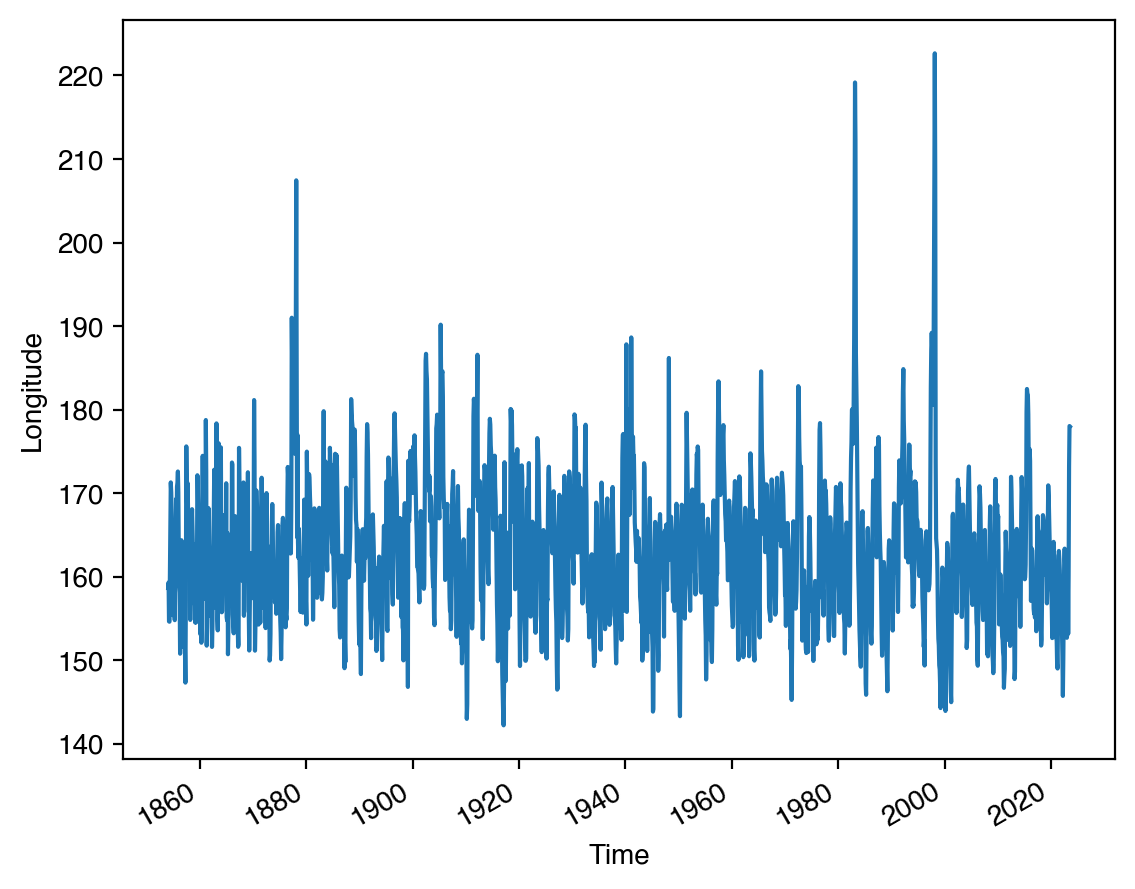

In [67]:
# check plot
eli.plot()
plt.ylabel('Longitude')
plt.xlabel('Time')

In [68]:
# create some seasonal indices
eli_djf =[]
eli_ndjfm = []